In [346]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Import Data

In [93]:
pod_number = 'D3'

In [94]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D3_raw_features.csv', parse_dates = [0], index_col = 0)

##Declare whether to process raw or filtered data.

In [95]:
which_data = 1    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Call the scaling function and create a dataframe with scaled data.

In [96]:
df_scaled, features = scale_features_and_create_day_column(df_all, ref_column)

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [158]:
df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

###Declare a cutoff value for 'high' ozone.

In [141]:
cutoff_value = 60

####Plot the training ozone

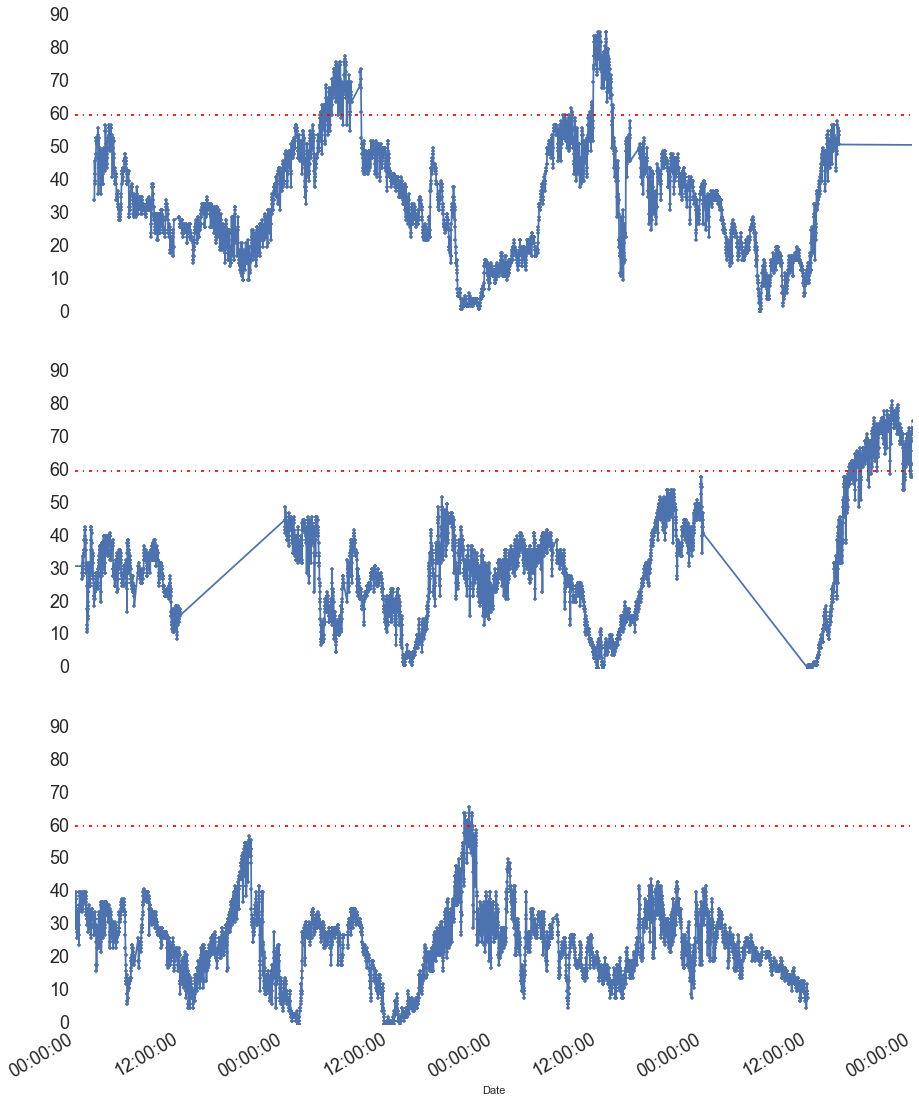

In [142]:
plot_tr_and_holdout(df_tr, pod_number, ref_column, 'Training Data', cutoff_value)

###Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

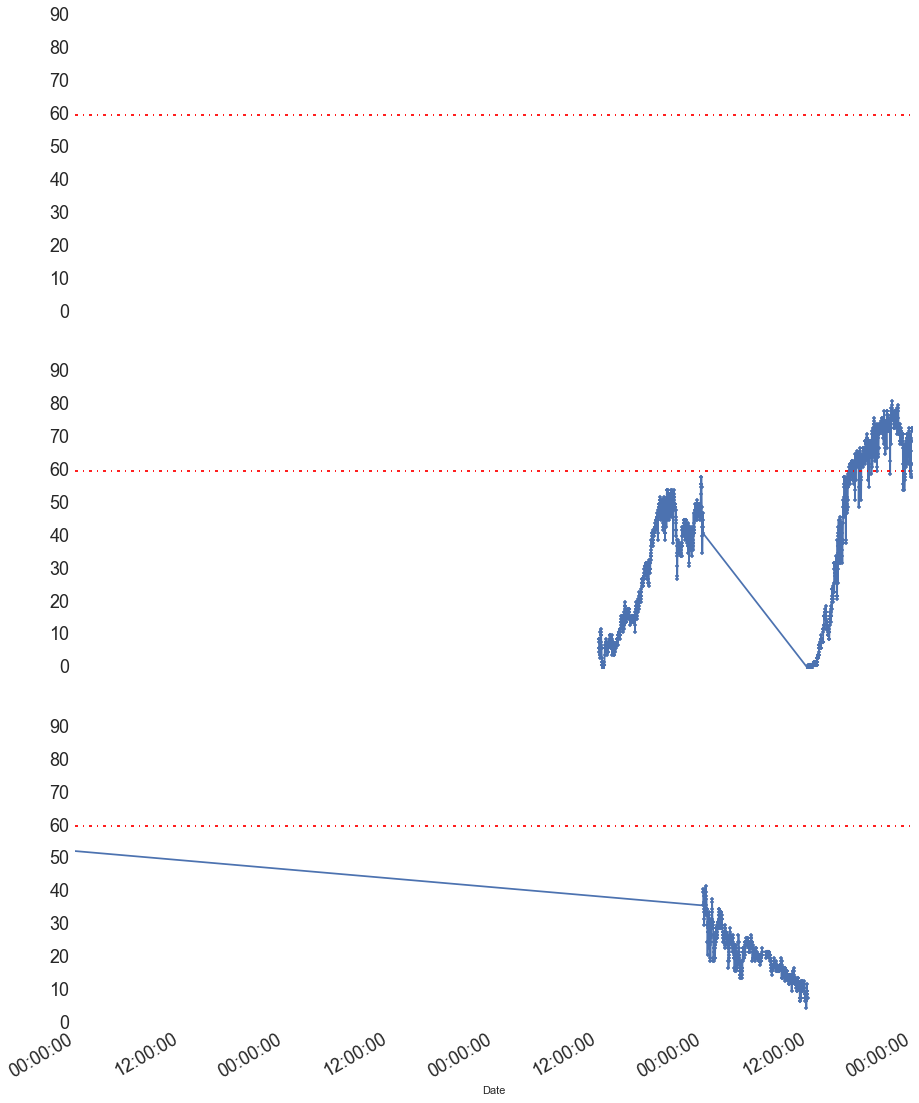

In [159]:
plot_tr_and_holdout(df_hold, pod_number, ref_column, 'Holdout Data', cutoff_value)

###Declare a multiplication factor for the MSE part of the custom score function.

In [160]:
cust_mse_fact = 1

#Linear Regression with Base Features

In [161]:
base_features = [pod_ozone,'Temp','Rh']

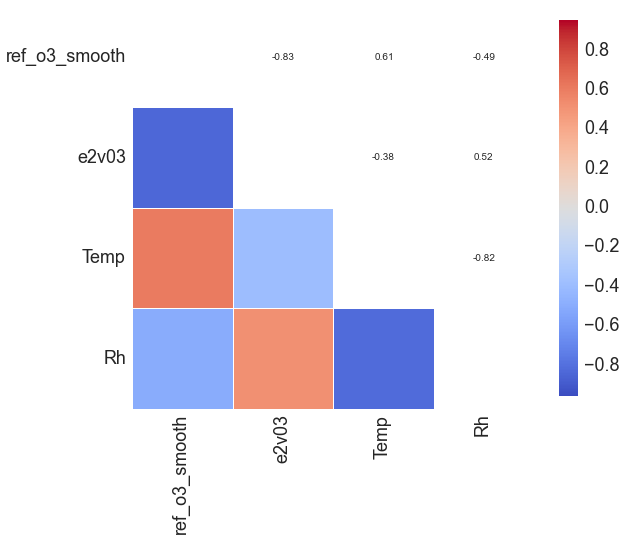

In [162]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [163]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 5.7
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 11.0 , CV High Diff. in Mean (>60): -10.4
Holdout RMSE: 6.0 , High-Value Holdout RMSE: 8.0 , Holdout High Diff. in Mean.: -7.1


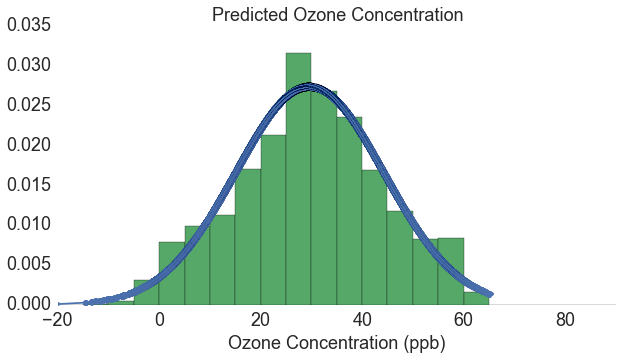

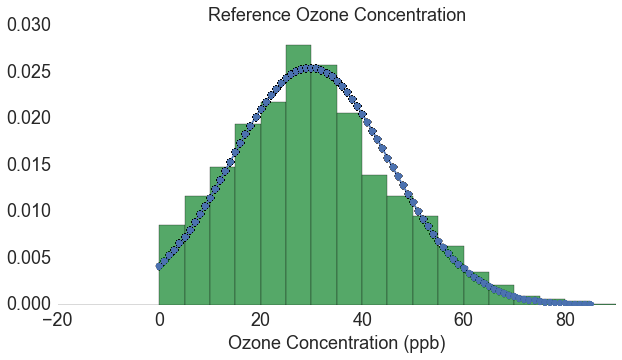

In [323]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

####Plot the learning curve for a linear regression with the base features.

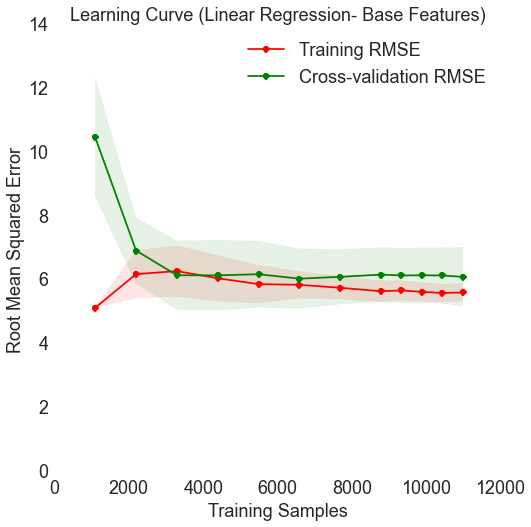

In [165]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,14), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

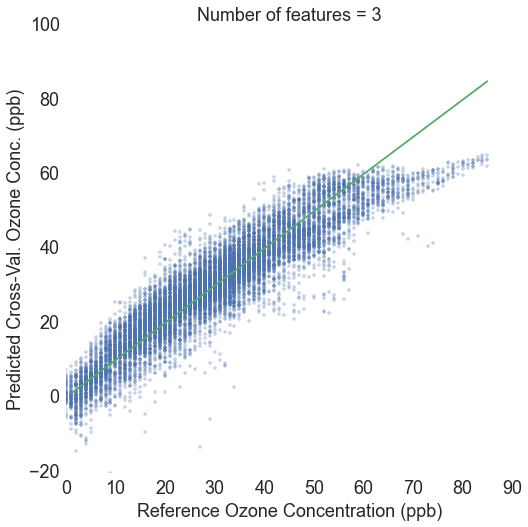

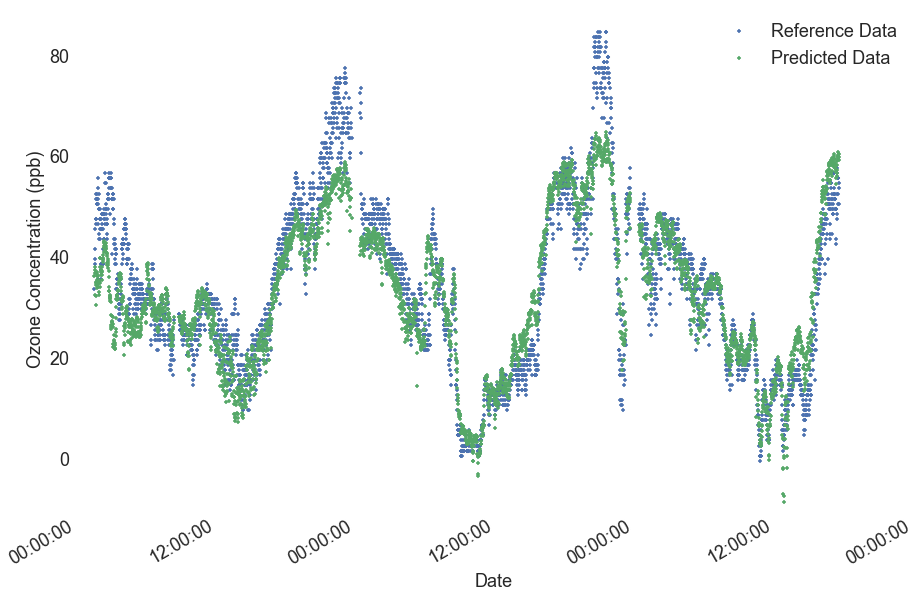

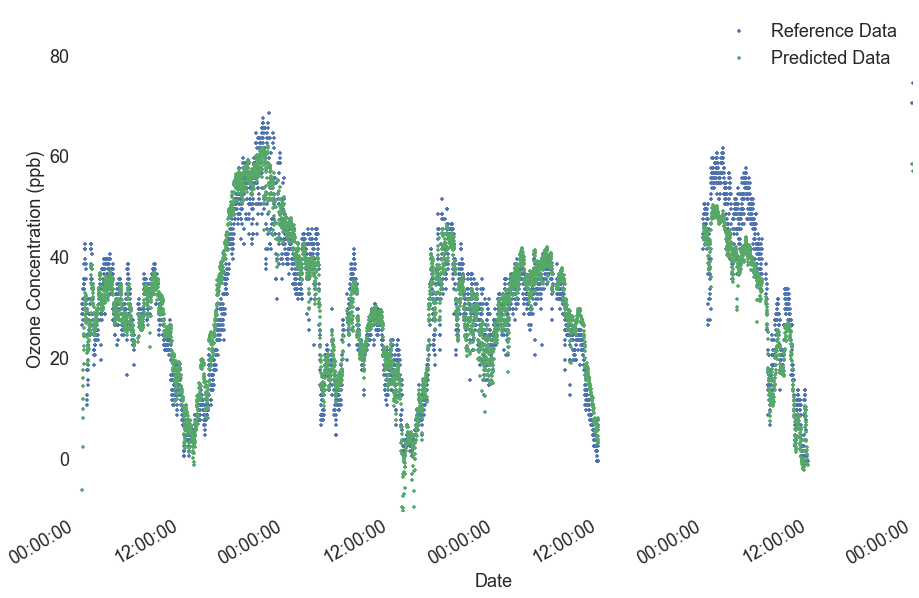

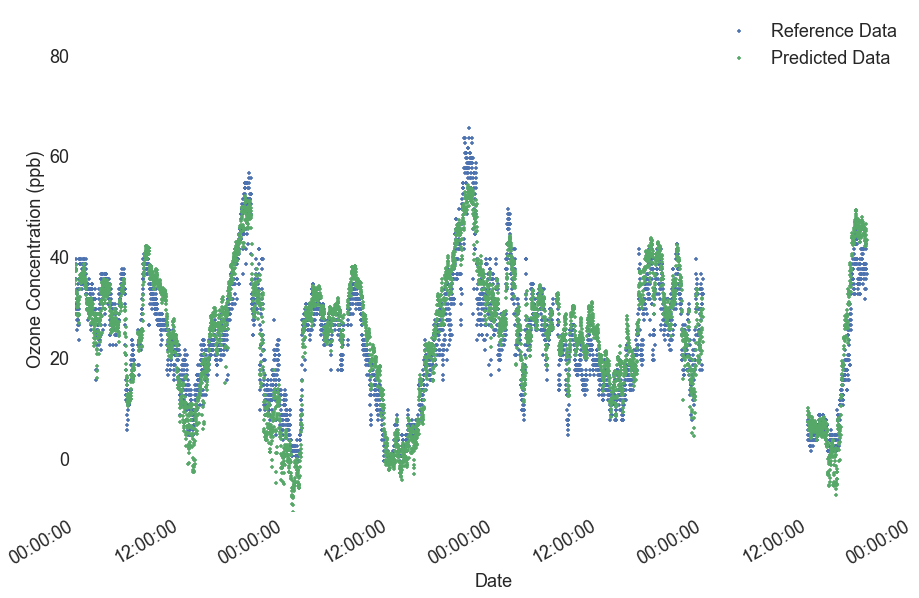

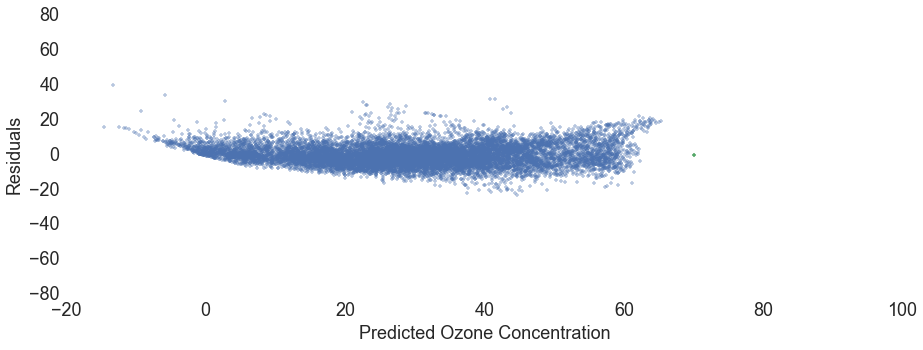

In [166]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 3, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

#Linear Regression with All Features.

In [167]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 3.3
Cross-Validation RMSE: 7.0 , High-Value CV RMSE: 10.0 , CV High Diff. in Mean (>60): -2.6
Holdout RMSE: 5.0 , High-Value Holdout RMSE: 8.0 , Holdout High Diff. in Mean.: 6.9


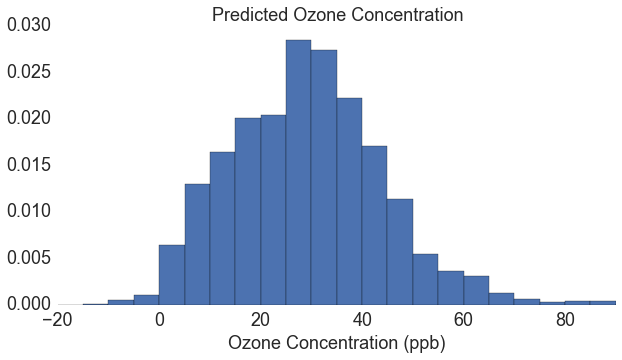

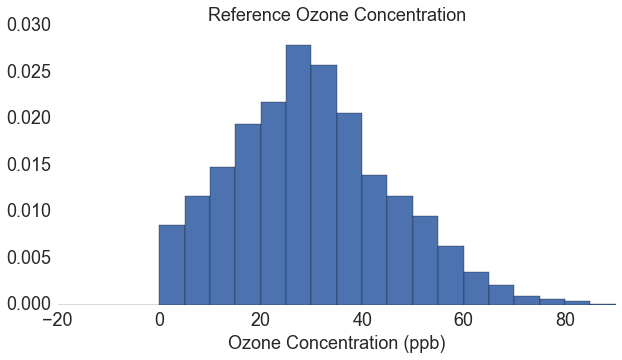

In [327]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

####Plot a learning curve with all features.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

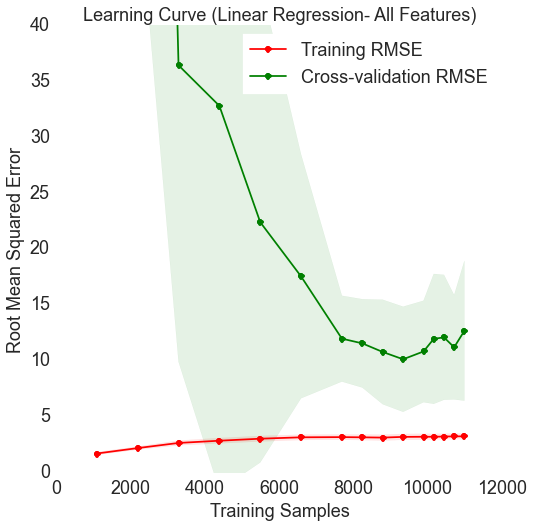

In [169]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- All Features)", df_tr[all_features].values, df_tr[ref_column].values, (0,40), 5, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 1.0]))

###Plot the residuals and comparison curves.

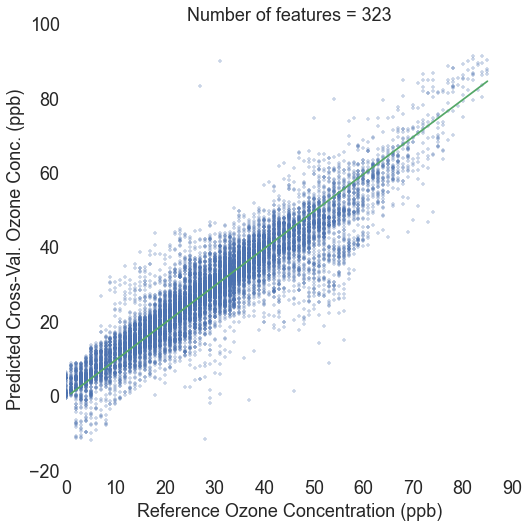

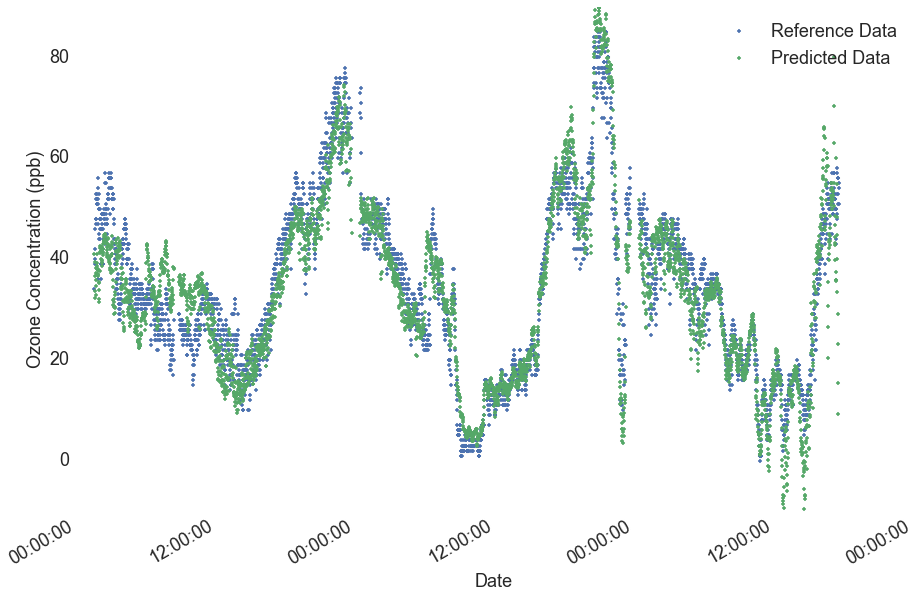

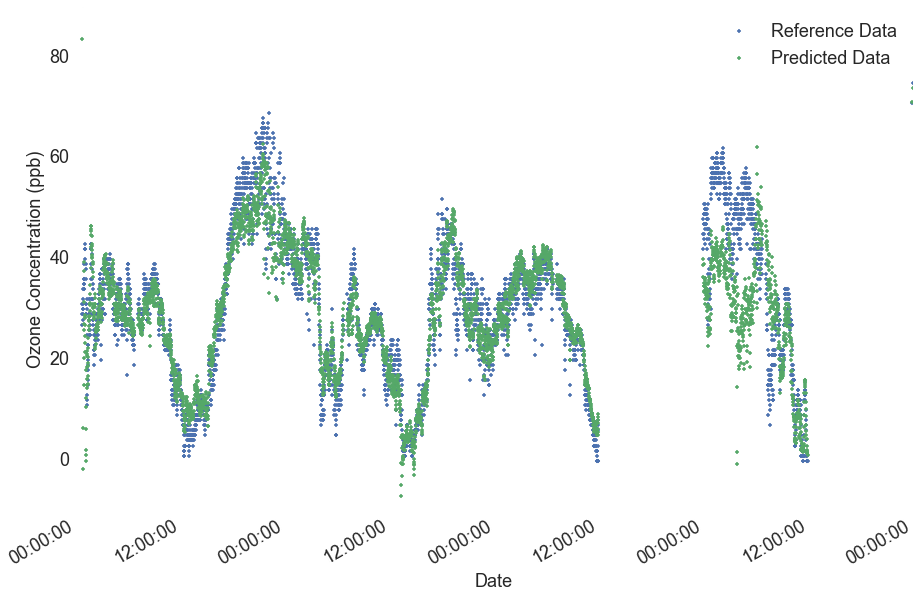

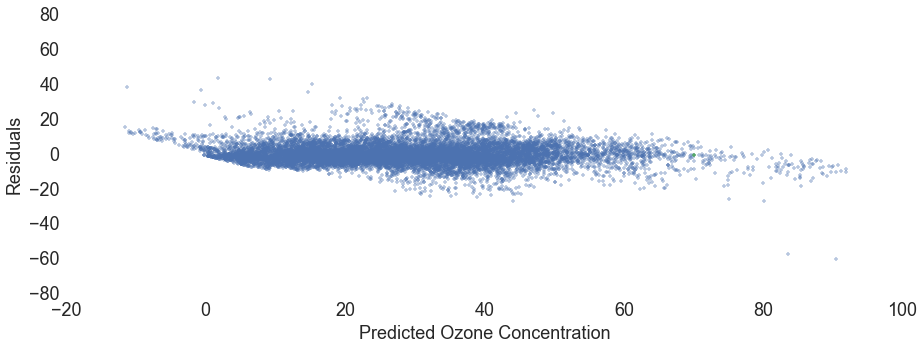

In [170]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [171]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 100, cust_mse_fact, cutoff_value)

Next best Feature:  ln_O3_int_lead_5 , Score:  14.9 RMSE:  6.4 #: 1
Next best Feature:  temp_cu , Score:  10.3 RMSE:  5.7 #: 2
Next best Feature:  ln_o3_temp_rh_int_lead_5 , Score:  6.0 RMSE:  5.6 #: 3
Next best Feature:  e2v03_slope_lag_90 , Score:  5.4 RMSE:  5.9 #: 4
Next best Feature:  ln_temp_rh_int_lag_90 , Score:  5.2 RMSE:  6.5 #: 5
Next best Feature:  Rh_slope_lag_30 , Score:  5.0 RMSE:  6.6 #: 6
Next best Feature:  e2v03_int_lag_5 , Score:  4.9 RMSE:  7.8 #: 7
Next best Feature:  o3_temp_int_lag_30 , Score:  4.7 RMSE:  6.4 #: 8
Next best Feature:  Rh_int_lead_15 , Score:  4.6 RMSE:  7.4 #: 9
Next best Feature:  o3_temp_int_lag_5 , Score:  4.4 RMSE:  20.0 #: 10
Next best Feature:  o3_temp_rh_slope_lag_30 , Score:  4.3 RMSE:  10.0 #: 11
Next best Feature:  o3_temp_slope_lag_60 , Score:  4.3 RMSE:  17.6 #: 12
Next best Feature:  ln_rh_int_lead_15 , Score:  4.2 RMSE:  15.5 #: 13
Next best Feature:  Rh_int_lead_5 , Score:  4.2 RMSE:  15.5 #: 14
Next best Feature:  ln_o3_temp_rh_sl

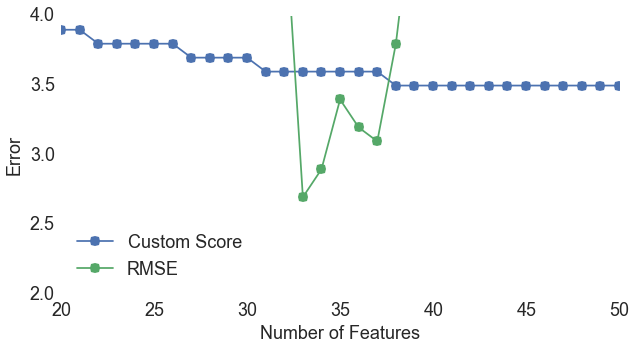

In [333]:
plot_error_vs_features(score, RMSE, [2,4], [20,50])

#Check Residuals

###Plot cross-validation fitted data versus reference data, and choose number of features.

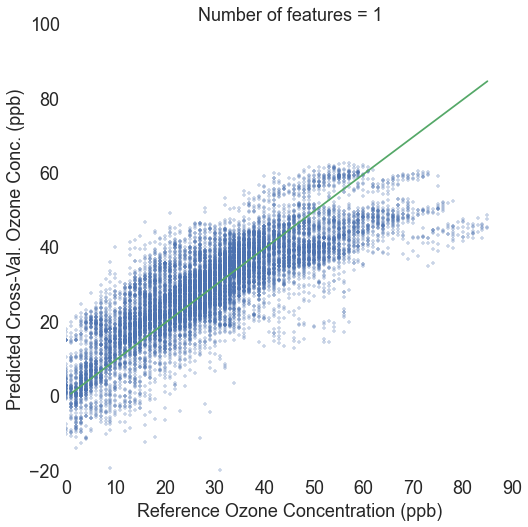

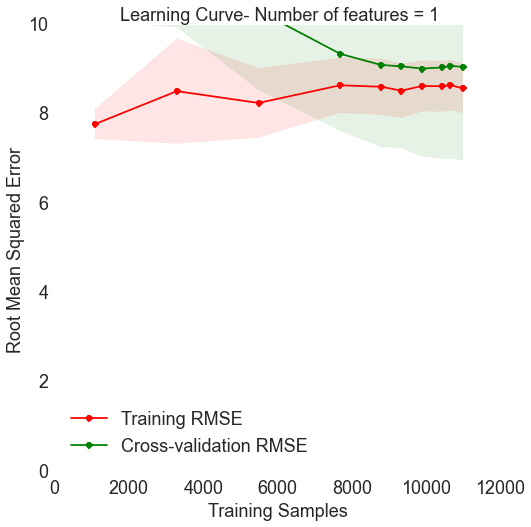

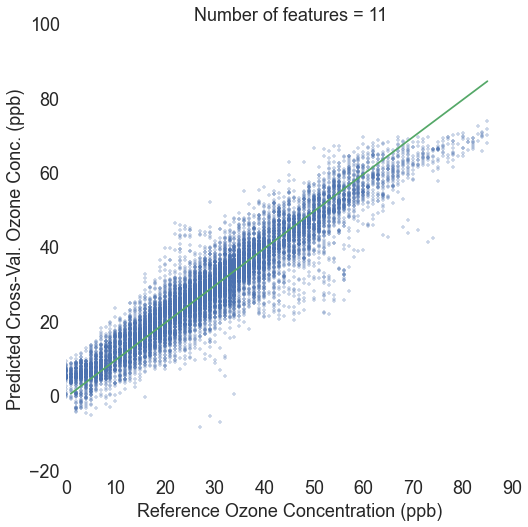

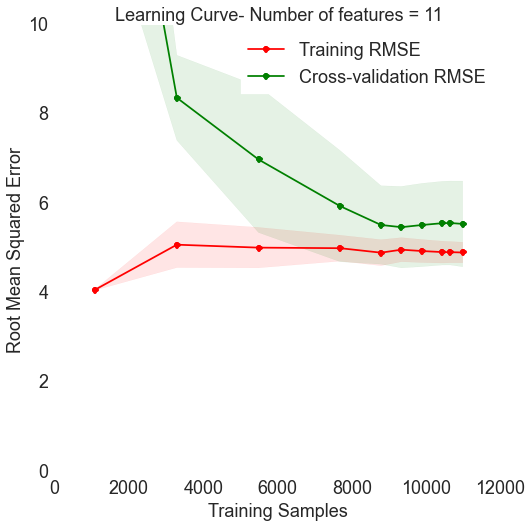

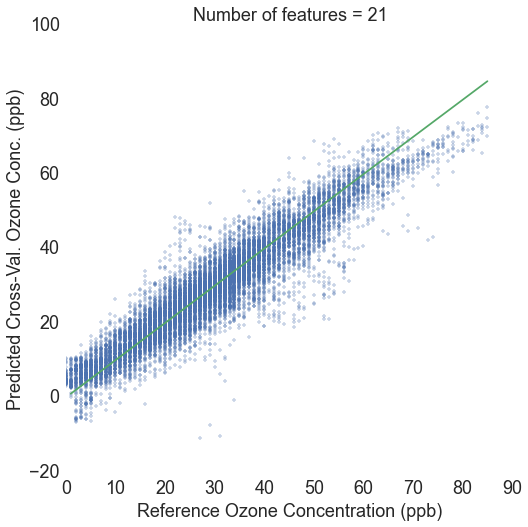

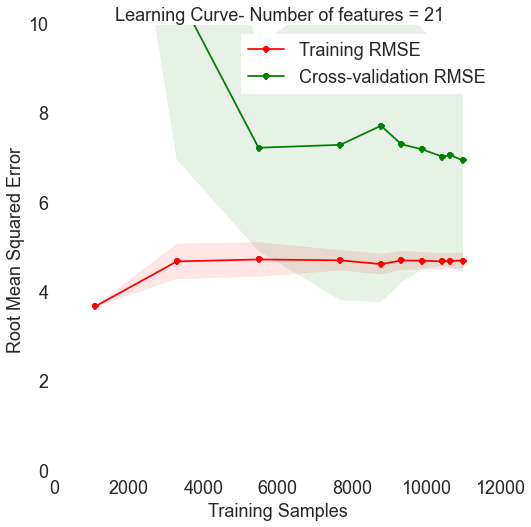

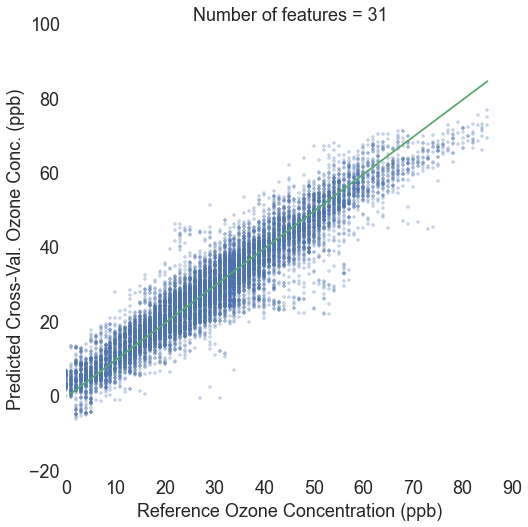

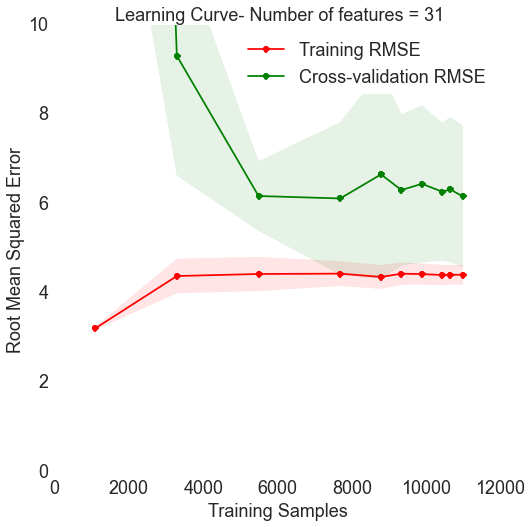

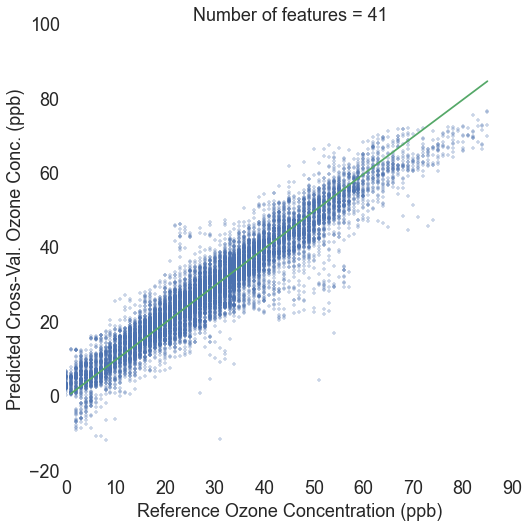

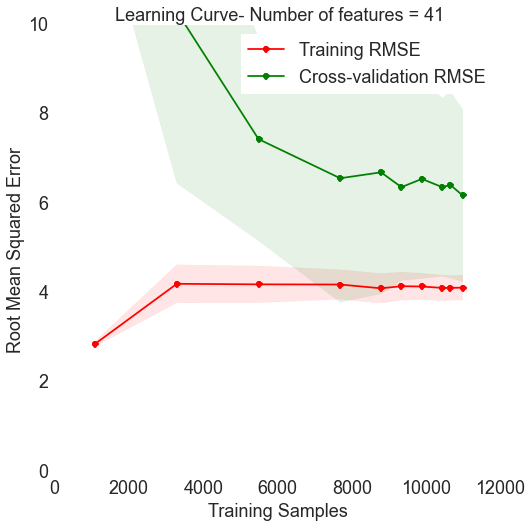

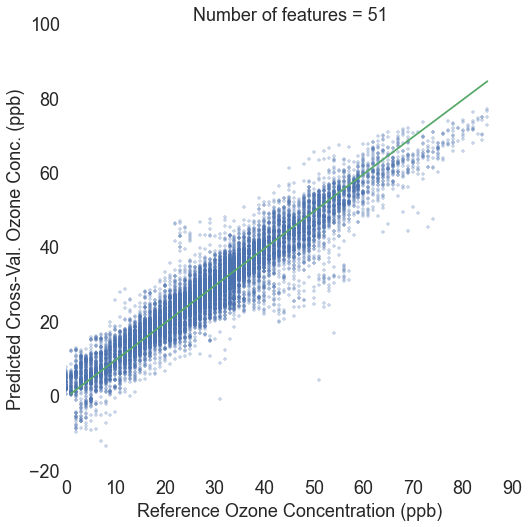

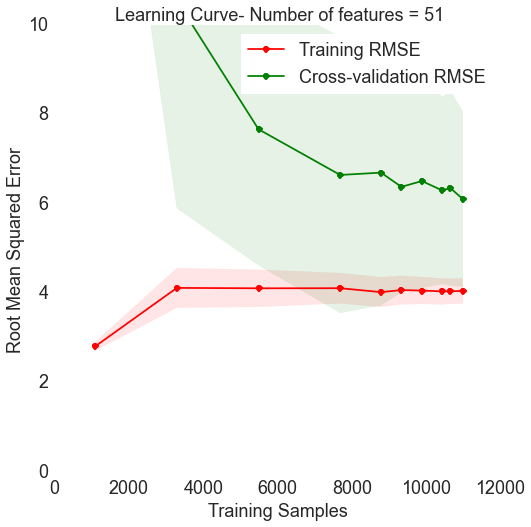

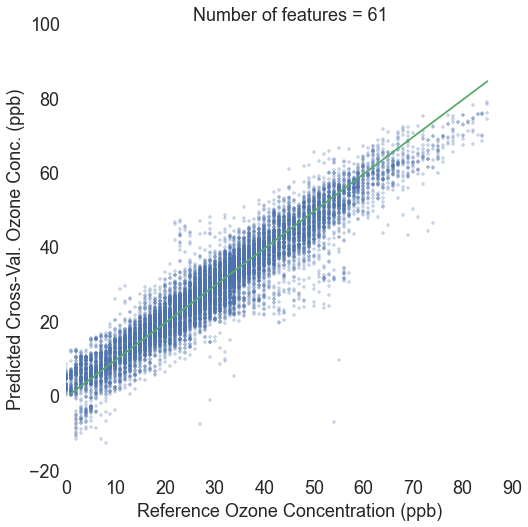

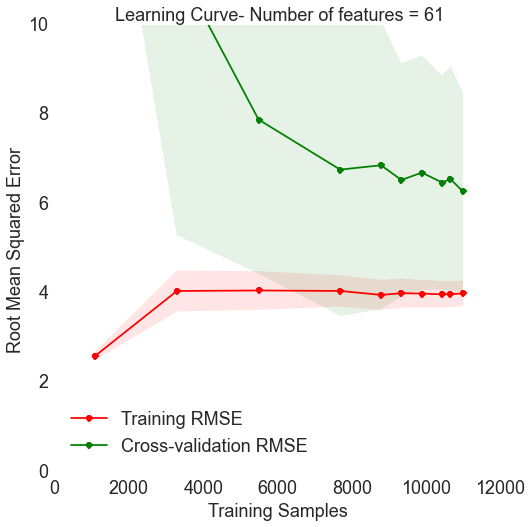

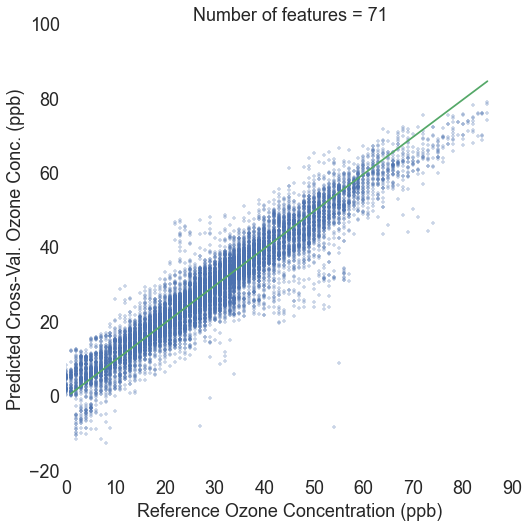

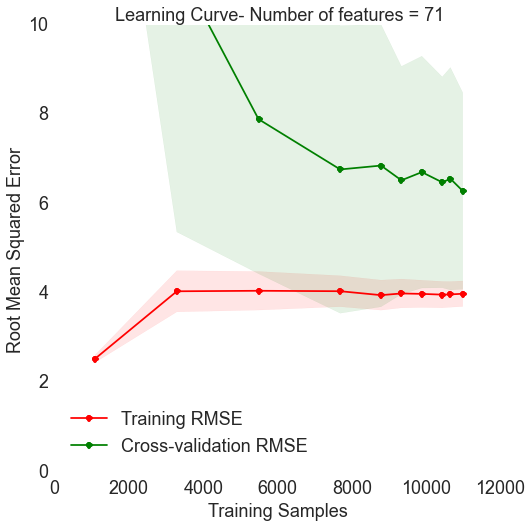

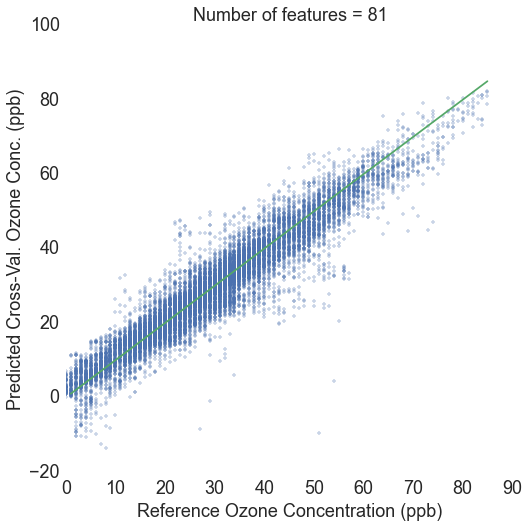

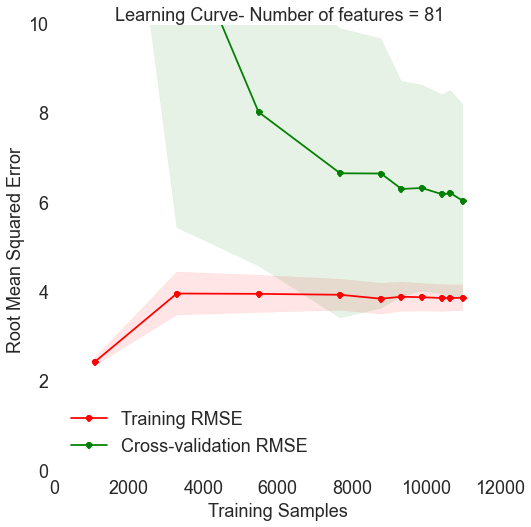

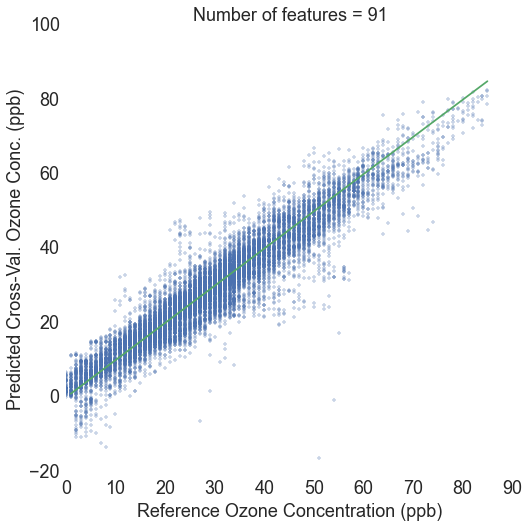

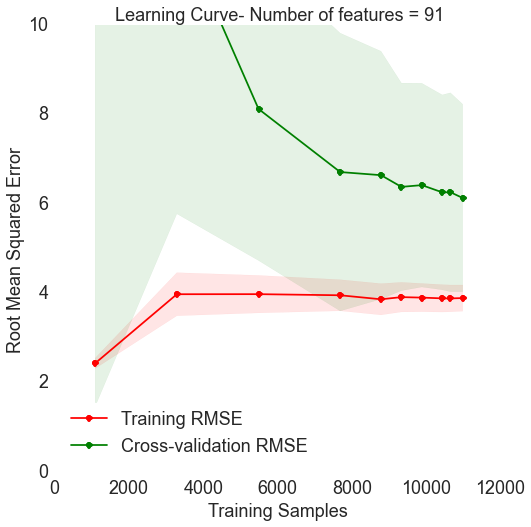

In [334]:
i = 1
while i < 100:
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,10), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 10

###Enter the chosen number of features, and perform a linear regression.

In [212]:
num_good_feat = 36
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 4.0
Cross-Validation RMSE: 4.0 , High-Value CV RMSE: 6.0 , CV High Diff. in Mean (>60): -1.9
Holdout RMSE: 3.0 , High-Value Holdout RMSE: 4.0 , Holdout High Diff. in Mean.: -2.2


### Plot the cross-validation data and residuals below.

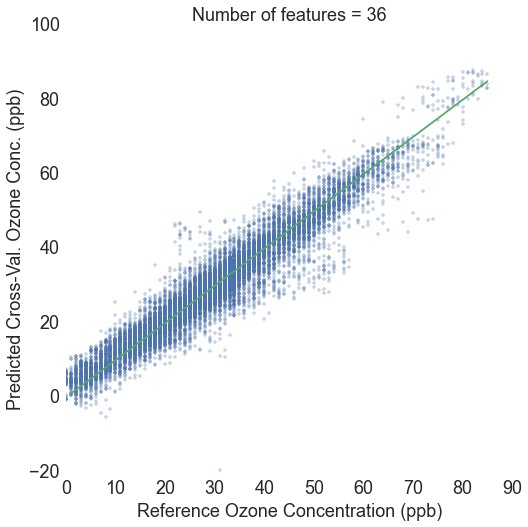

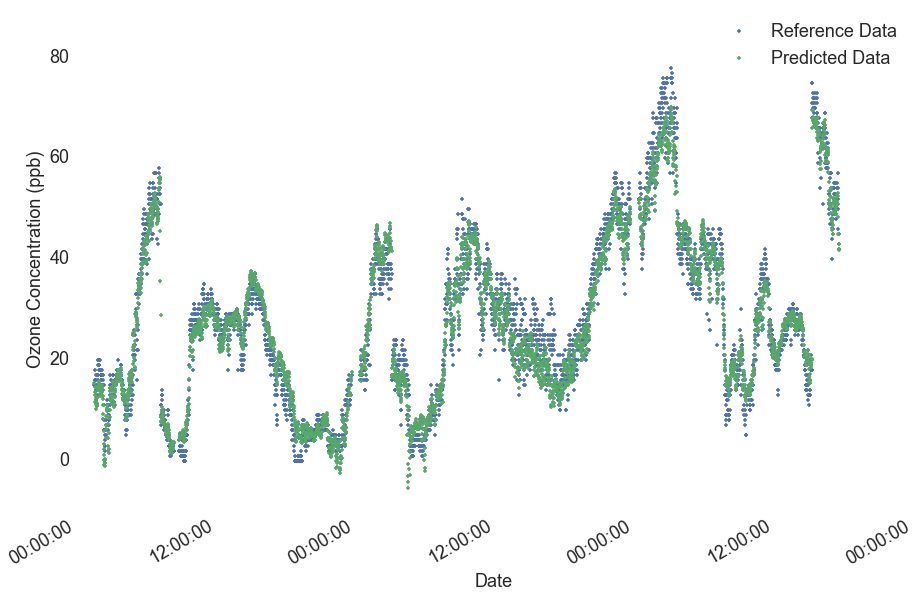

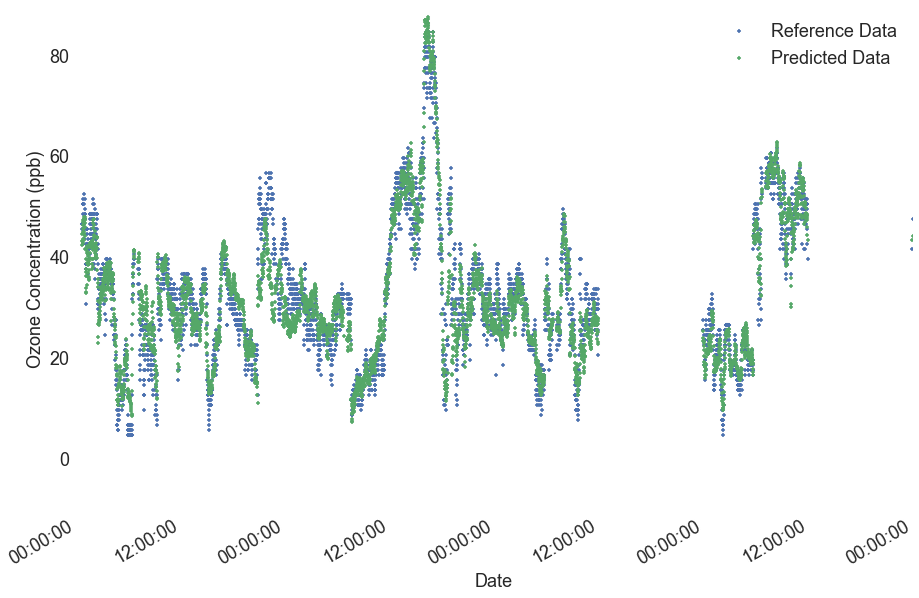

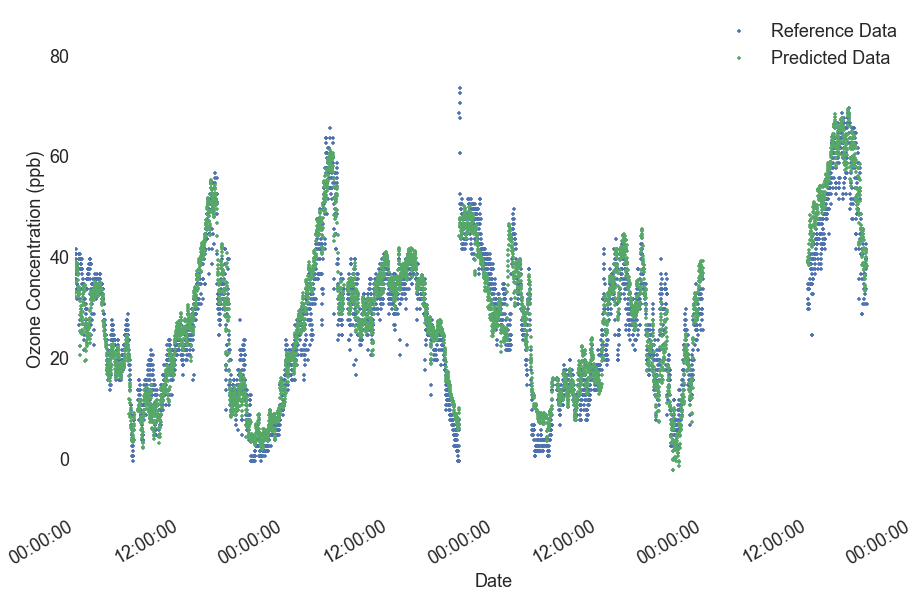

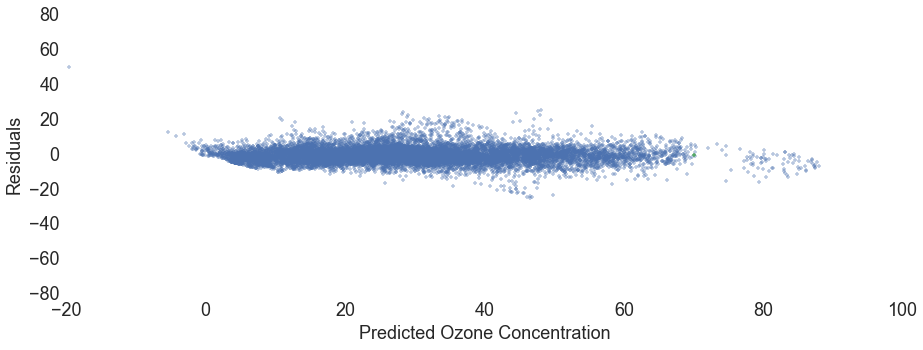

In [214]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 3, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

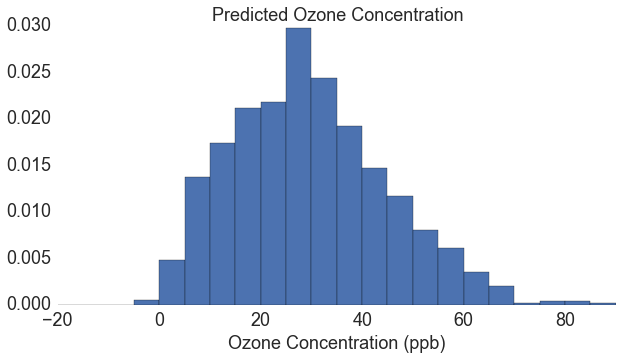

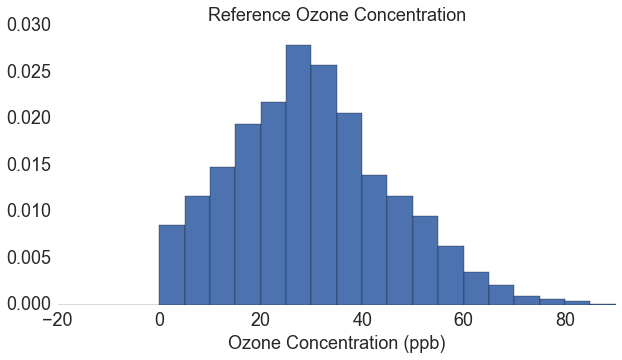

In [335]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

#Ridge Regression

In [216]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [217]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

###Find the best lambda value using cross-validation

In [221]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 7.21
lambda: 3e-07
score: 7.27
lambda: 9e-07
score: 7.39
lambda: 2.7e-06
score: 7.54
lambda: 8.1e-06
score: 7.63
lambda: 2.43e-05
score: 7.6
lambda: 7.29e-05
score: 7.46
lambda: 0.0002187
score: 7.2
lambda: 0.0006561
score: 6.85
lambda: 0.0019683
score: 6.52
lambda: 0.0059049
score: 6.31
lambda: 0.0177147
score: 6.29
lambda: 0.0531441
score: 6.32
lambda: 0.1594323
score: 6.33
lambda: 0.4782969
score: 6.24
lambda: 1.4348907
score: 6.09
lambda: 4.3046721
score: 5.97
lambda: 12.9140163
score: 5.98
lambda: 38.7420489
score: 6.03
lambda: 116.2261467
score: 6.18
lambda: 348.6784401
score: 6.5
lambda: 1046.0353203
score: 7.06
lambda: 3138.1059609
score: 7.93
lambda: 9414.3178827
score: 9.34
lambda: 28242.9536481
score: 11.73
lambda: 84728.8609443
score: 15.39
lambda: 254186.582833
score: 20.16
lambda: 762559.748499
score: 25.73
Best Lambda: 4.3046721


###Plot the values of lambda versus the coefficients and the custom score. 

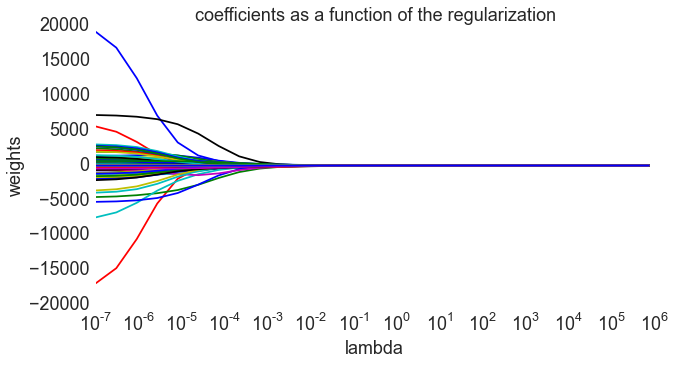

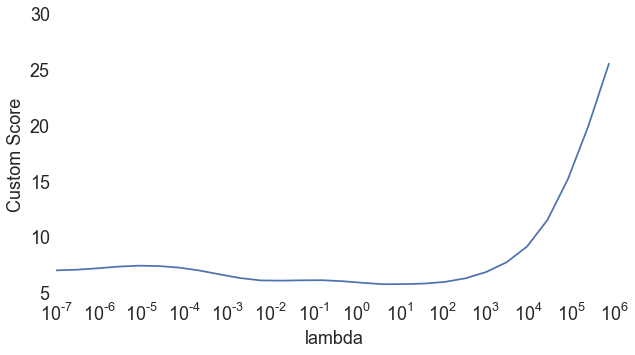

In [222]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

####Use the best lambda value found above to find errors.

In [225]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 3.5
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 7.0 , CV High Diff. in Mean (>60): -3.0
Holdout RMSE: 4.0 , High-Value Holdout RMSE: 4.0 , Holdout High Diff. in Mean.: -3.0


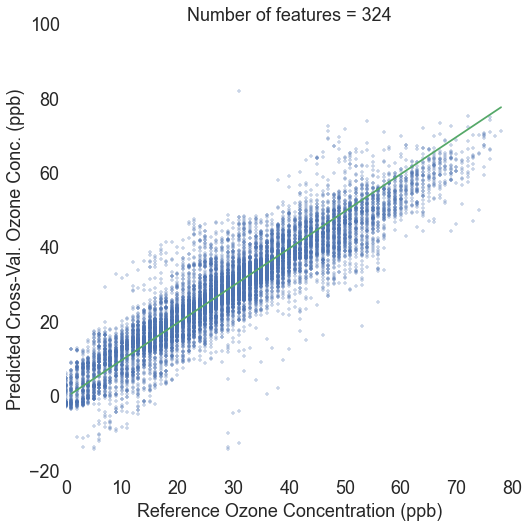

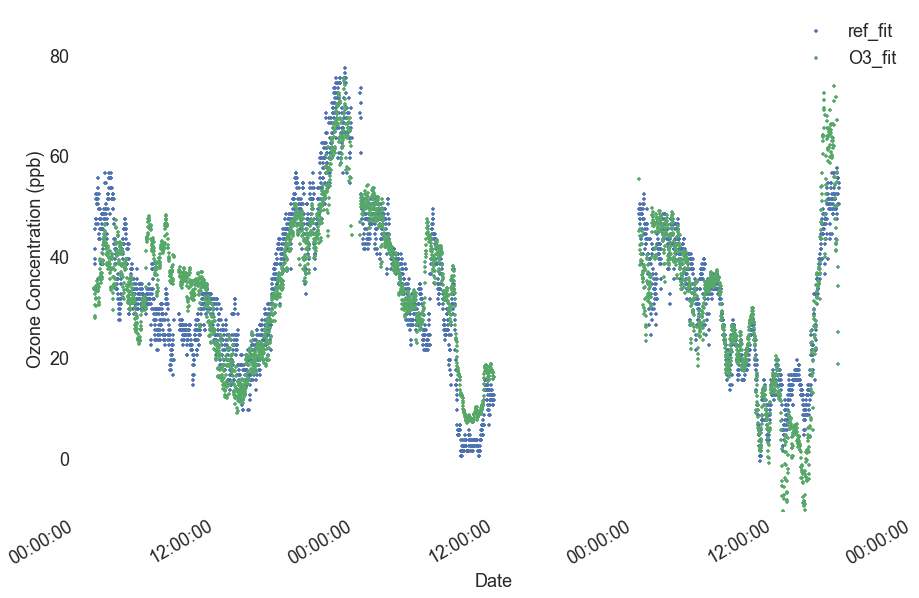

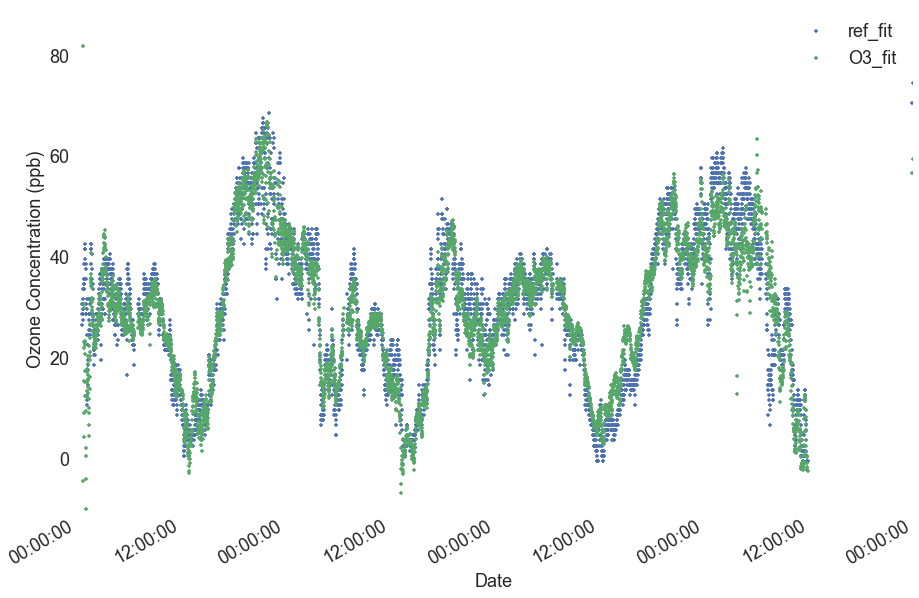

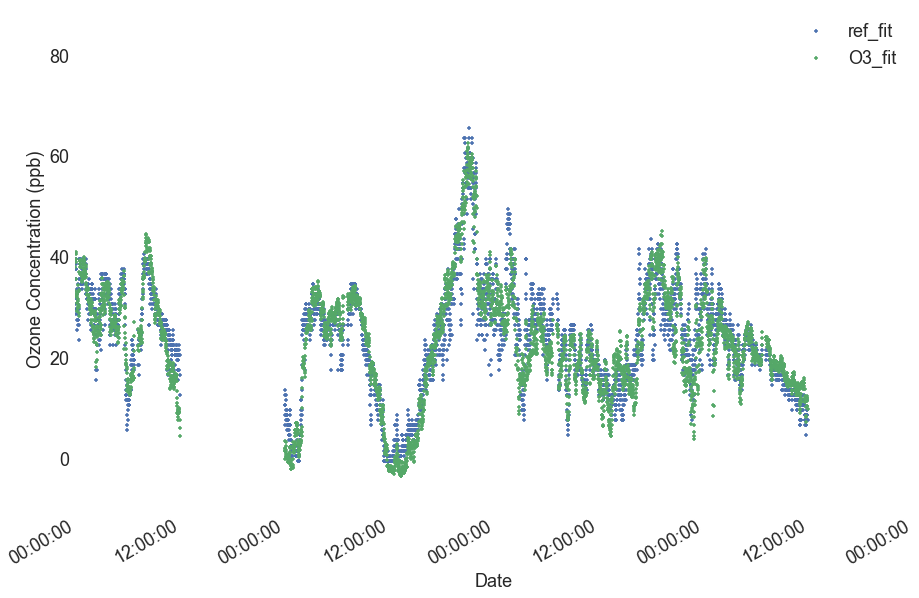

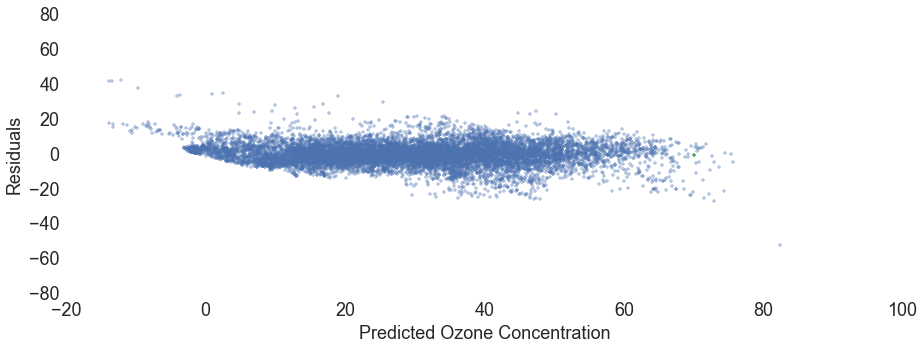

In [170]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 3, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge, ref_column)

#Lasso

In [228]:
best_lambda_lasso, lambda_lasso, coefs_lasso, mean_score_lambda_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-06
score: 6.02
lambda: 3e-06
score: 6.02
lambda: 9e-06
score: 6.02
lambda: 2.7e-05
score: 6.01
lambda: 8.1e-05
score: 6.01
lambda: 0.000243
score: 5.98
lambda: 0.000729
score: 5.9
lambda: 0.002187
score: 5.71
lambda: 0.006561
score: 5.49
lambda: 0.019683
score: 5.73
lambda: 0.059049
score: 6.3
lambda: 0.177147
score: 7.48
lambda: 0.531441
score: 9.49
lambda: 1.594323
score: 14.61
lambda: 4.782969
score: 23.21
lambda: 14.348907
score: 38.06
lambda: 43.046721
score: 38.06
Best Lambda: 0.006561


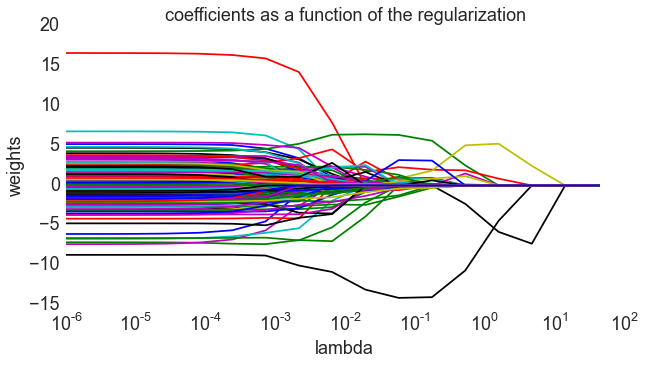

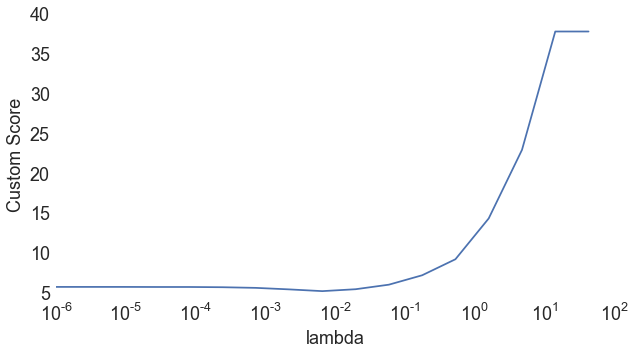

In [229]:
plot_lambda(lambda_lasso, coefs_lasso, mean_score_lambda_lasso)

####Use the best lambda value found above to find holdout values.

In [231]:
MSE_CV_lasso, MSE_T_lasso, MSE_H_lasso, high_MSE_cv_lasso, X_pred_cv_lasso, y_cv_lasso, df_cv_lasso, df_H_lasso = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 3.7
Cross-Validation RMSE: 5.0 , High-Value CV RMSE: 6.0 , CV High Diff. in Mean (>60): -3.7
Holdout RMSE: 3.0 , High-Value Holdout RMSE: 4.0 , Holdout High Diff. in Mean.: -3.0


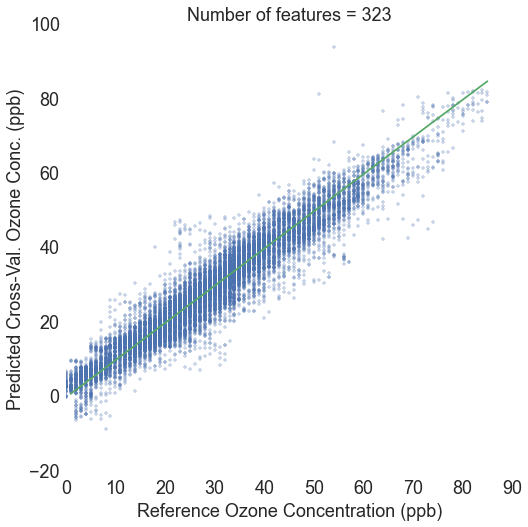

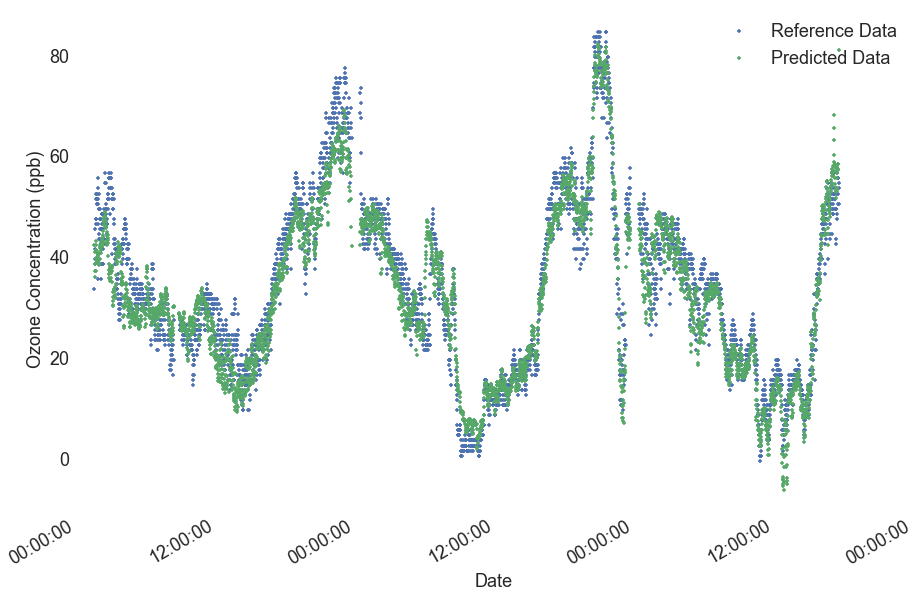

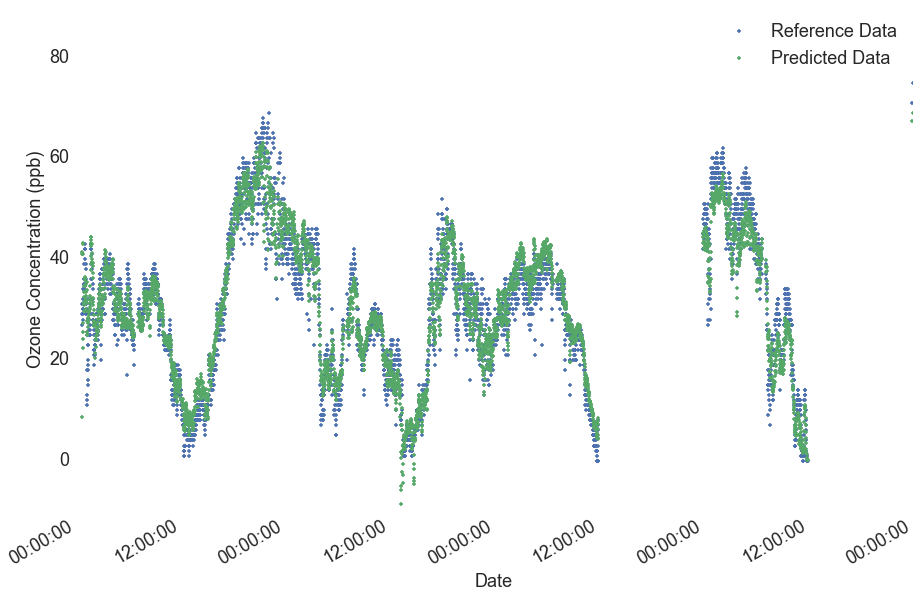

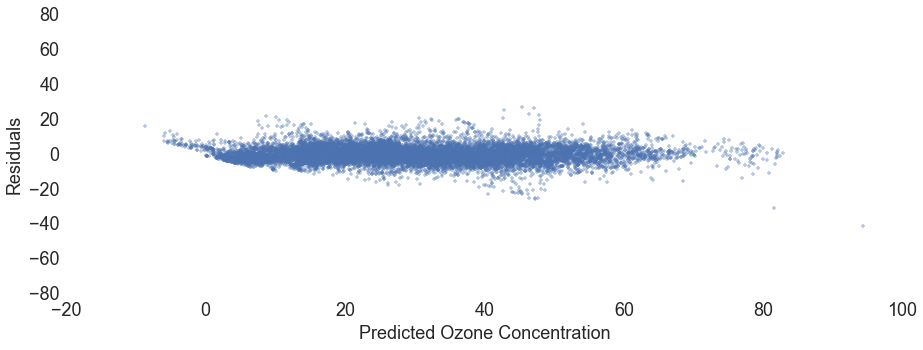

In [232]:
fitted_vs_ref_plot(df_cv_lasso, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso, ref_column)

##Random Forest with all features.

In [291]:
fs_features = features_it
num_good_feat = len(fs_features)

In [292]:
#choose to run default parameters or look for the best parameters (0 = default, 1 = other)
options = 0

In [293]:
if options == 0:
    RMSE_CV_rf_all, df_fit_rf_all = find_MSE_random_forest(df_tr, fs_features, days_tr, options, ref_column)
else:
    RMSE_CV_all = find_MSE_random_forest(df_tr, fs_features, chunks_tr, options, ref_column)

7-8 Cross-Validation RMSE:  9.5
7-9 Cross-Validation RMSE:  9.3
7-10 Cross-Validation RMSE:  6.4
8-21 Cross-Validation RMSE:  5.3
8-22 Cross-Validation RMSE:  5.6
8-23 Cross-Validation RMSE:  3.0
8-24 Cross-Validation RMSE:  9.1
8-25 Cross-Validation RMSE:  8.1
8-26 Cross-Validation RMSE:  6.1
8-27 Cross-Validation RMSE:  4.5
8-28 Cross-Validation RMSE:  6.1
8-29 Cross-Validation RMSE:  4.4


In [339]:
if options == 1:
    print 'Daily RMSE = ', round(RMSE_CV_rf_all, 1)
    print 'mean RMSE = ', round(RMSE_CV_rf_all.mean(axis=2, dtype = int), 1)
    df_fit_rf_all = find_fitted_cv_values_for_best_features(df_tr, fs_features, num_good_feat, sk.RandomForestRegressor(n_estimators=300, oob_score = True, n_jobs = -1), chunks_tr, ref_column)
else: 
    print 'mean RMSE = ', int(np.mean(RMSE_CV_rf_all))
    print 'Daily RMSE = ' + str(RMSE_CV_rf_all)

mean RMSE =  6
Daily RMSE = [[[ 9.53939201  9.32737905  6.40312424  5.29150262  5.56776436  3.
    9.05538514  8.06225775  6.08276253  4.47213595  6.08276253  4.35889894]]]


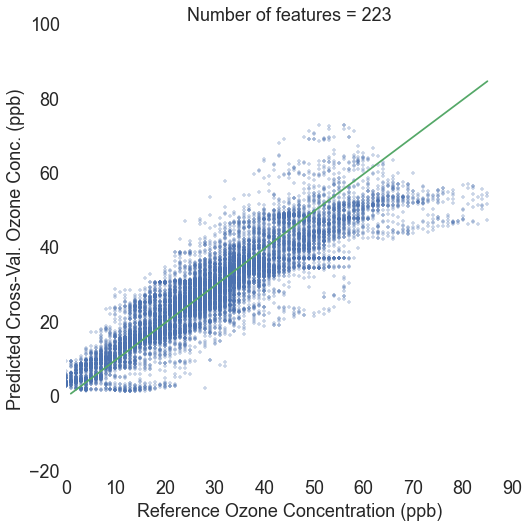

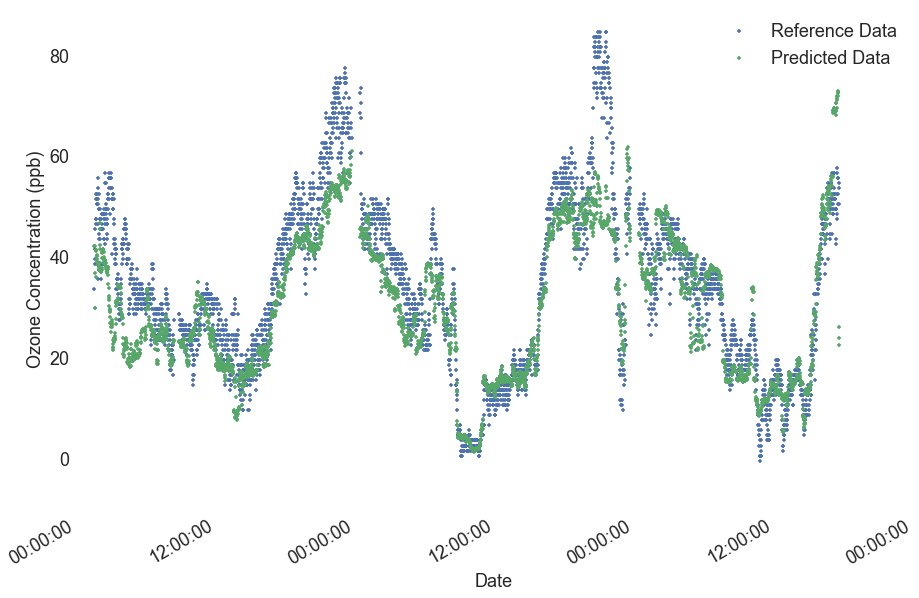

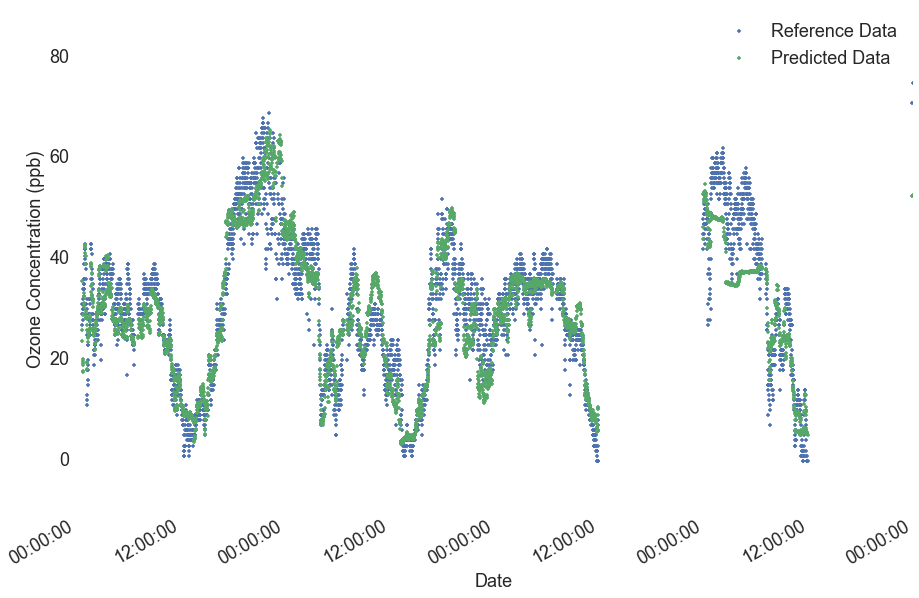

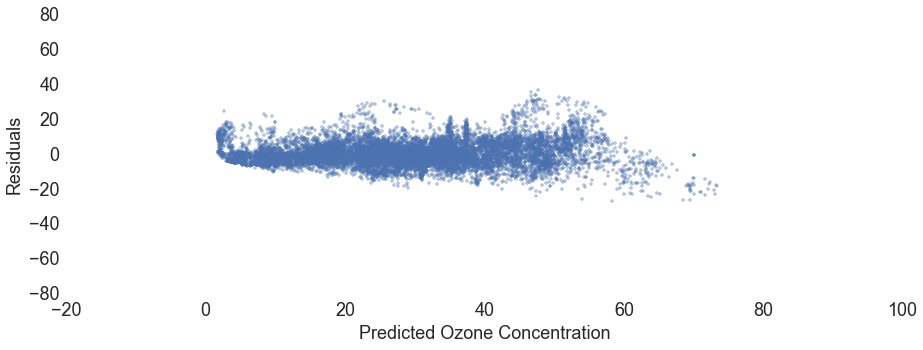

In [296]:
fitted_vs_ref_plot(df_fit_rf_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_all, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_all, ref_column)

##Random Forest with best features.

In [283]:
if options == 0:
    RMSE_CV_rf_best, df_fit_rf_best = find_MSE_random_forest(df_tr, best_features, days_tr, options, ref_column)
else:
    RMSE_CV_rf_best = find_MSE_random_forest(df_tr, best_features, chunks_tr, options, ref_column)

7-8 Cross-Validation RMSE:  8.9
7-9 Cross-Validation RMSE:  9.3
7-10 Cross-Validation RMSE:  5.7
8-21 Cross-Validation RMSE:  5.2
8-22 Cross-Validation RMSE:  4.2
8-23 Cross-Validation RMSE:  3.7
8-24 Cross-Validation RMSE:  6.5
8-25 Cross-Validation RMSE:  8.3
8-26 Cross-Validation RMSE:  4.8
8-27 Cross-Validation RMSE:  3.7
8-28 Cross-Validation RMSE:  5.0
8-29 Cross-Validation RMSE:  5.0


In [286]:
if options == 1:
    print 'Daily RMSE = ', RMSE_CV_rf_best
    print 'mean RMSE = ', RMSE_CV_rf_best.mean(axis=2, dtype = int)
    df_fit_rf_best = find_fitted_cv_values_for_best_features(df_tr, best_features, num_good_feat, sk.RandomForestRegressor(n_estimators=300, oob_score = True, n_jobs = -1), chunks_tr, ref_column)
else: 
    print 'mean RMSE = ', int(np.mean(RMSE_CV_rf_best))
    print 'Daily RMSE = ' + str(RMSE_CV_rf_best)    

 mean RMSE =  5
Daily RMSE = [[[ 8.94427191  9.32737905  5.65685425  5.19615242  4.24264069  3.74165739
    6.4807407   8.30662386  4.79583152  3.74165739  5.          5.        ]]]


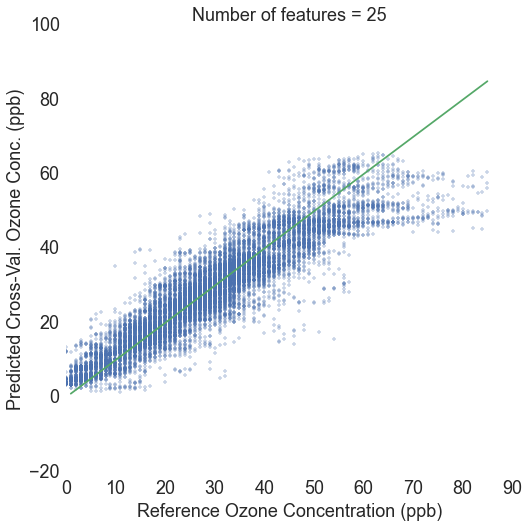

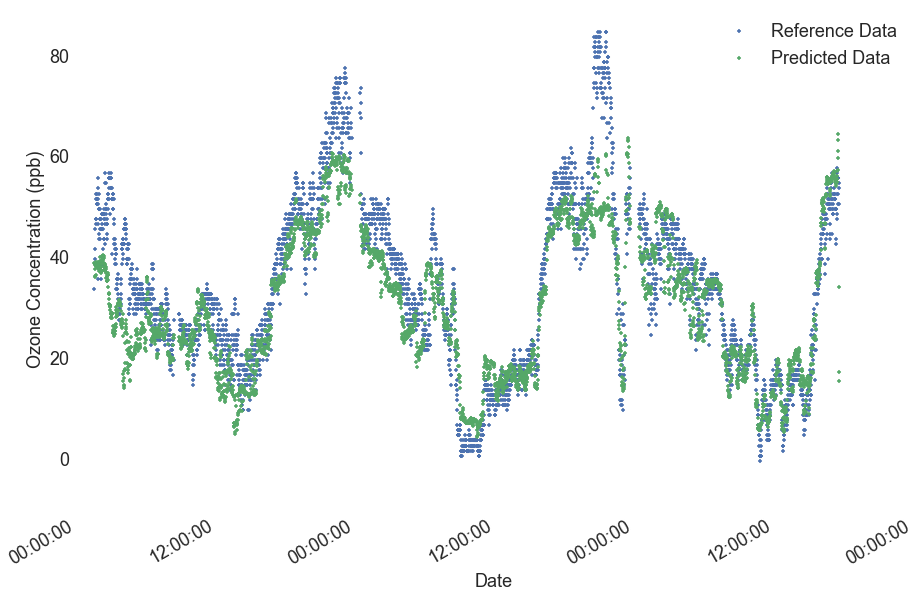

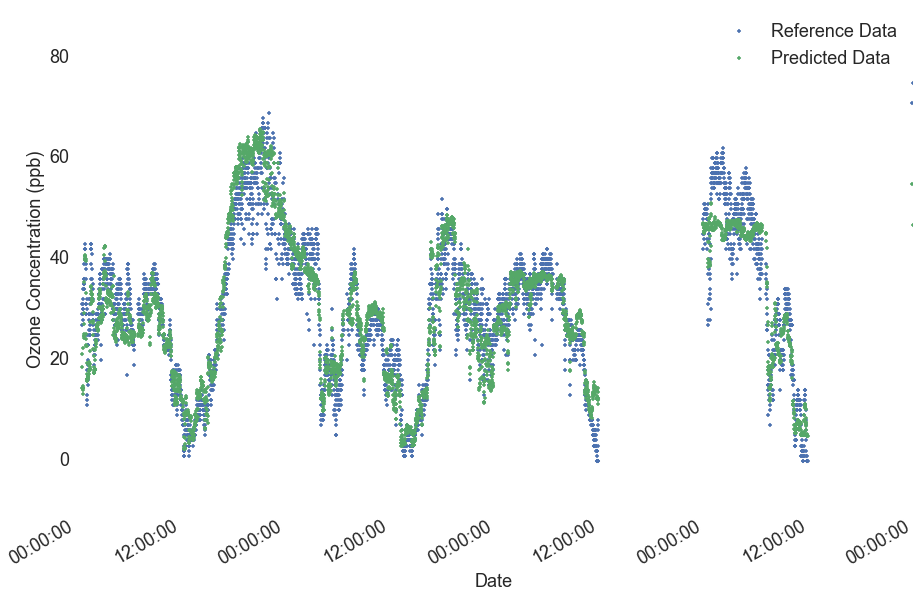

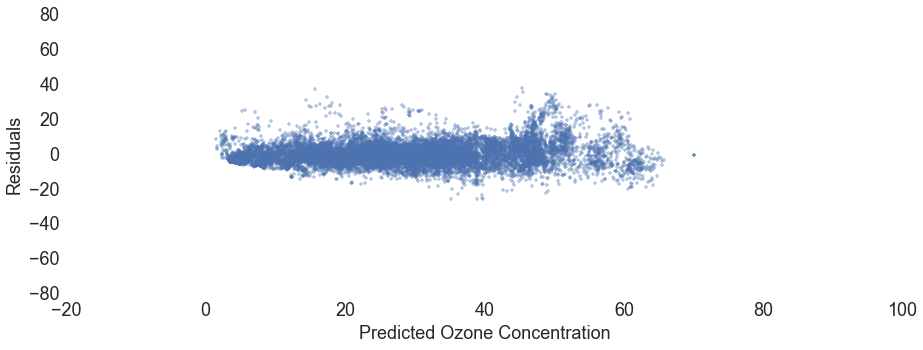

In [287]:
fitted_vs_ref_plot(df_fit_rf_best, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_best, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_best, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_best, ref_column)

#Support Vector Machine

In [355]:
RMSE_CV_day, df_svm_fit = fit_vsm_and_find_MSE(best_features, df_tr, days_tr, ref_column)  

KeyboardInterrupt: 

In [345]:
vsm.get_params

<bound method GridSearchCV.get_params of GridSearchCV(cv=None,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)>

In [ ]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

In [ ]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

def fit_vsm_and_find_MSE(features, df_T, df_H, d, days, fitted_holdout_o3, lol):
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = SVR()
    vsm = GridSearchCV(svr, parameters, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False), cv = lol)
    vsm.fit(X_T, y_T)  
    
    
    if d == days[0]:
        fitted_holdout_o3 = vsm.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, vsm.predict(X_H)))
        
    MSE_CV = int(np.mean((y_H - vsm.predict(X_H))**2))
    
    print d,'Cross-Val MSE: ', MSE_CV
    print vsm.get_params
    return MSE_CV, fitted_holdout_o3

In [ ]:
def avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric):
    X = df[features].values
    y = df[ref_column].values
    if scoring_metric == 'custom_mse':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False)))        
    elif scoring_metric == 'custom_mae':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mae_scoring_function, greater_is_better = False)))        
    else:
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = scoring_metric))
    return score_cv